In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

hardware_name = "RTX6000Ada"
double_count_memory = False

matmul_gpu_run = pd.read_csv(
    f"results/matmul_{hardware_name}_gpu_tmp.csv", header=None, names=["M", "N", "K", "latency", "throughput", "power", "energy", "frequency", ""]
)
matmul_gpu_run["throughput"] = (
    matmul_gpu_run["throughput"].str.extract(r"(\d+\.?\d*)").astype(float)
)
matmul_gpu_run.set_index(["M", "N", "K"], inplace=True)

matmul_gpu_sim = pd.read_csv(
    f"results/matmul_{hardware_name}_sim_mem_tuning.csv", header=None, names=["M", "N", "K", "latency", "throughput", "power", "total", "memory_to_l2_transfer", "l2_to_l1_transfer", "l1_to_l0_transfer", "compute"]
)
matmul_gpu_sim["throughput"] = (
    matmul_gpu_sim["throughput"].str.extract(r"(\d+\.?\d*)").astype(float)
)
matmul_gpu_sim.set_index(["M", "N", "K"], inplace=True)

color_NV = sns.color_palette("Greens_d", 4)[1:]

In [26]:
compute_energy_factor = 1
if hardware_name == "RTX6000Ada":
    #compute_energy_factor = 1.865901109520493/0.8
    compute_energy_factor = 1.3686619758322982/0.8
elif hardware_name == "RTX4090":
    #compute_energy_factor = 2.678223581517877/0.8
    compute_energy_factor = 2.266325809091007/0.8
elif hardware_name == "L4":
    #compute_energy_factor = 1.6545940773642525/0.8
    compute_energy_factor = 1.2642540352105016/0.8
    
    
# compute_energy_factor = 1

# if hardware_name == "RTX6000Ada":
#     compute_energy_factor = 1.470307229993248/0.8 if double_count_memory else 0.9730680963050534/0.8
# elif hardware_name == "RTX4090":
#     compute_energy_factor = 2.203423708005748/0.8 if double_count_memory else 1.7915259355788777/0.8
# elif hardware_name == "L4":
#     compute_energy_factor = 1.365728068870071/0.8 if double_count_memory else 0.9753880267163201/0.8

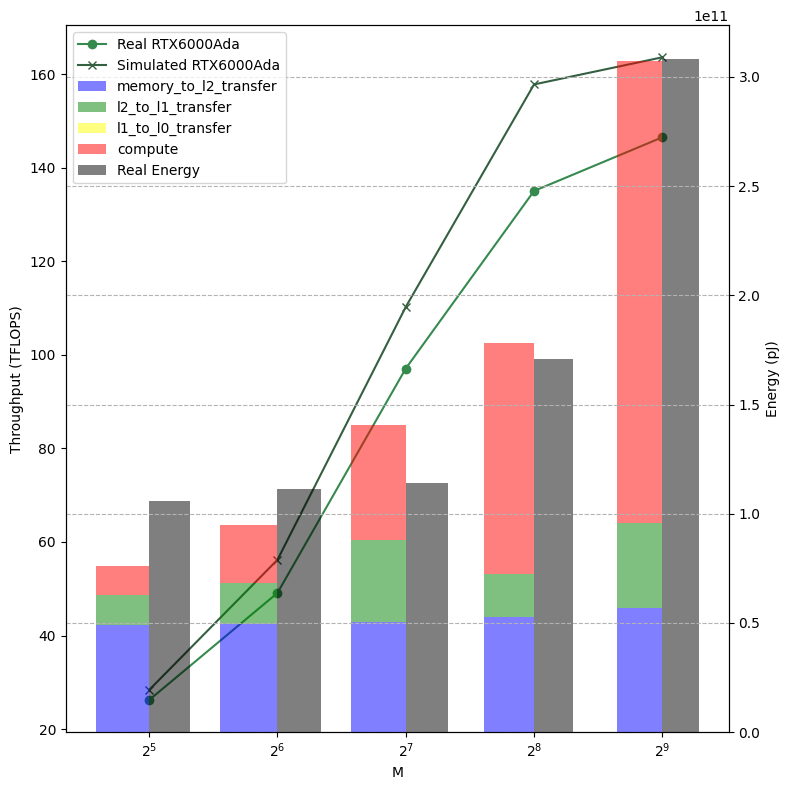

<Figure size 640x480 with 0 Axes>

In [27]:
K = 12288
N = K
title = f"Performance of Matmul with K={K}, N={N}"
M_list = []

throughput_GPU_run_list = []
energy_GPU_run_list = []
throughput_GPU_sim_list = []
energy_GPU_sim_list = [[] for _ in range(4)]
for M in range(5, 10):
    M = 2**M
    M_list.append(M)
    throughput_GPU_run_list.append(matmul_gpu_run.loc[(M, N, K), "throughput"])
    energy_GPU_run_list.append(matmul_gpu_run.loc[(M, N, K), "energy"])
    throughput_GPU_sim_list.append(matmul_gpu_sim.loc[(M, N, K), "throughput"])
    energy_GPU_sim_list[0].append(matmul_gpu_sim.loc[(M, N, K), "memory_to_l2_transfer"] / (2 if double_count_memory else 1))
    energy_GPU_sim_list[1].append(matmul_gpu_sim.loc[(M, N, K), "l2_to_l1_transfer"] / (2 if double_count_memory else 1))
    energy_GPU_sim_list[2].append(matmul_gpu_sim.loc[(M, N, K), "l1_to_l0_transfer"] / (2 if double_count_memory else 1))
    energy_GPU_sim_list[3].append(matmul_gpu_sim.loc[(M, N, K), "compute"] * compute_energy_factor)

fig, ax1 = plt.subplots(figsize=(8, 8))

ax1.set_xscale("log", base=2)
ax1.set_xlabel("M")
ax1.plot(M_list, throughput_GPU_run_list, marker="o", label=f"Real {hardware_name}", color=color_NV[1])
ax1.plot(M_list, throughput_GPU_sim_list, marker="x", label=f"Simulated {hardware_name}", color=color_NV[2])
ax1.set_ylabel('Throughput (TFLOPS)')

ax2 = ax1.twinx()
#ax2.set_yscale("log")
M_list = np.array(M_list)
bar_widths = ((M_list - 2**4) * 2) / np.log2(M_list - 2**4)
ax2.bar(M_list - (bar_widths / 2), energy_GPU_sim_list[0], width=bar_widths, label='memory_to_l2_transfer', color='blue', alpha=0.5)
bottom = energy_GPU_sim_list[0]
ax2.bar(M_list - (bar_widths / 2), energy_GPU_sim_list[1], width=bar_widths, bottom=bottom, label='l2_to_l1_transfer', color='green', alpha=0.5)
bottom = [i + j for i, j in zip(bottom, energy_GPU_sim_list[1])]
ax2.bar(M_list - (bar_widths / 2), energy_GPU_sim_list[2], width=bar_widths, bottom=bottom, label='l1_to_l0_transfer', color='yellow', alpha=0.5)
bottom = [i + j for i, j in zip(bottom, energy_GPU_sim_list[2])]
ax2.bar(M_list - (bar_widths / 2), energy_GPU_sim_list[3], width=bar_widths, bottom=bottom, label='compute', color='red', alpha=0.5)
ax2.set_ylabel('Energy (pJ)')

ax2.bar(M_list + (bar_widths / 2), energy_GPU_run_list, width = bar_widths, label='Real Energy', color='black', alpha=0.5)

ax2.plot([], [], marker="o", label=f"Real {hardware_name}", color=color_NV[1])
ax2.plot([], [], marker="x", label=f"Simulated {hardware_name}", color=color_NV[2])

ax2.legend(loc='upper left')

plt.grid(True, which="both", ls="--", c="0.7")  # Adding a grid for better readability
plt.tight_layout()
plt.show()
plt.savefig("figure5b.pdf", bbox_inches="tight", pad_inches=0.01, dpi=300)


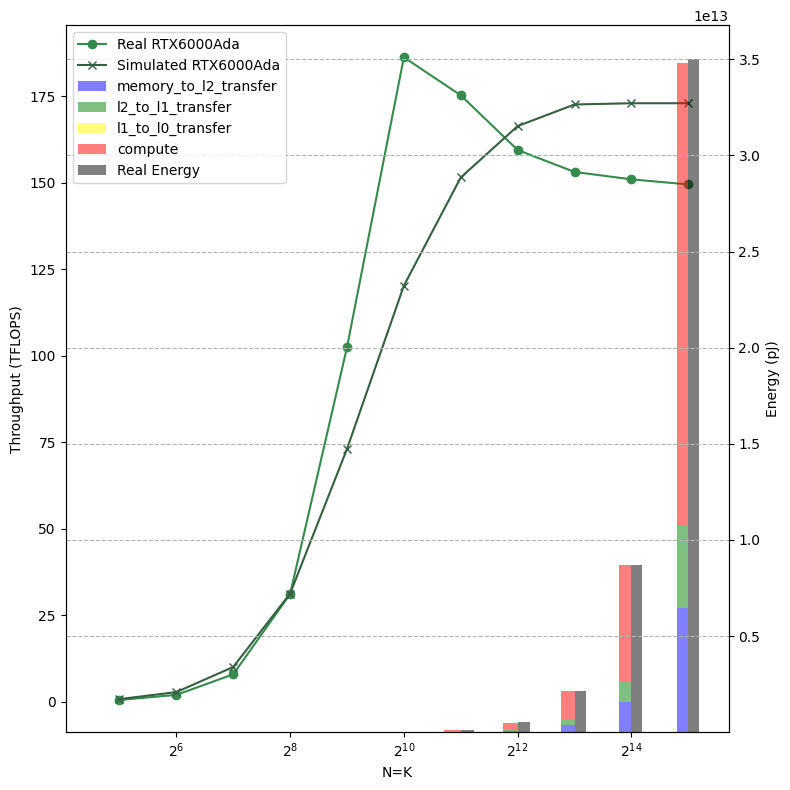

<Figure size 640x480 with 0 Axes>

In [28]:

M = 8192
title = f"Performance of Matmul with M={M}"
K_list = []

throughput_GPU_run_list = []
energy_GPU_run_list = []
throughput_GPU_sim_list = []
energy_GPU_sim_list = [[] for _ in range(4)]
for K in range(5, 16):
    K = 2**K
    N = K
    K_list.append(K)
    throughput_GPU_run_list.append(matmul_gpu_run.loc[(M, N, K), "throughput"])
    energy_GPU_run_list.append(matmul_gpu_run.loc[(M, N, K), "energy"])
    throughput_GPU_sim_list.append(matmul_gpu_sim.loc[(M, N, K), "throughput"])
    energy_GPU_sim_list[0].append(matmul_gpu_sim.loc[(M, N, K), "memory_to_l2_transfer"] / (2 if double_count_memory else 1))
    energy_GPU_sim_list[1].append(matmul_gpu_sim.loc[(M, N, K), "l2_to_l1_transfer"] / (2 if double_count_memory else 1))
    energy_GPU_sim_list[2].append(matmul_gpu_sim.loc[(M, N, K), "l1_to_l0_transfer"] / (2 if double_count_memory else 1))
    energy_GPU_sim_list[3].append(matmul_gpu_sim.loc[(M, N, K), "compute"] * compute_energy_factor)

fig, ax1 = plt.subplots(figsize=(8, 8))

ax1.set_xscale("log", base=2)
ax1.set_xlabel("N=K")

ax1.plot(K_list, throughput_GPU_run_list, marker="o", label=f"Real {hardware_name}", color=color_NV[1])
ax1.plot(K_list, throughput_GPU_sim_list, marker="x", label=f"Simulated {hardware_name}", color=color_NV[2])
ax1.set_ylabel('Throughput (TFLOPS)')

ax2 = ax1.twinx()
#ax2.set_yscale("log")
K_list = np.array(K_list)
bar_widths = ((K_list - 2**4) * 2) / np.log2(K_list - 2**4)
ax2.bar(K_list - (bar_widths / 2), energy_GPU_sim_list[0], width=bar_widths, label='memory_to_l2_transfer', color='blue', alpha=0.5)
bottom = energy_GPU_sim_list[0]
ax2.bar(K_list - (bar_widths / 2), energy_GPU_sim_list[1], width=bar_widths, bottom=bottom, label='l2_to_l1_transfer', color='green', alpha=0.5)
bottom = [i + j for i, j in zip(bottom, energy_GPU_sim_list[1])]
ax2.bar(K_list - (bar_widths / 2), energy_GPU_sim_list[2], width=bar_widths, bottom=bottom, label='l1_to_l0_transfer', color='yellow', alpha=0.5)
bottom = [i + j for i, j in zip(bottom, energy_GPU_sim_list[2])]
ax2.bar(K_list - (bar_widths / 2), energy_GPU_sim_list[3], width=bar_widths, bottom=bottom, label='compute', color='red', alpha=0.5)
ax2.set_ylabel('Energy (pJ)')

ax2.bar(K_list + (bar_widths / 2), energy_GPU_run_list, width = bar_widths, label='Real Energy', color='black', alpha=0.5)

ax2.plot([], [], marker="o", label=f"Real {hardware_name}", color=color_NV[1])
ax2.plot([], [], marker="x", label=f"Simulated {hardware_name}", color=color_NV[2])

ax2.legend(loc='upper left')

plt.grid(True, which="both", ls="--", c="0.7")  # Adding a grid for better readability
plt.tight_layout()
plt.show()
plt.savefig("figure5a.pdf", bbox_inches="tight", pad_inches=0.01, dpi=300)